In [1]:
import pandas as pd
import numpy as np
import sklearn.metrics as metrics
from random import randint
from matplotlib import pyplot as plt

In [96]:
import datetime
from common import get_full_data
from ucimlrepo import fetch_ucirepo 
from df_encodings import label_encode


# load data
def steel_strength():
    df = pd.read_csv("dataset/steel_strength.csv")
    # get dependent and independent features
    X=df.iloc[:,1:-3]
    y=df.iloc[:,-2]
    return get_full_data(X,y)

def renewable():
    df = pd.read_csv("dataset/Renewable.csv")
    time = df["Time"].apply(lambda x: datetime.datetime.fromisoformat(x))
    df=df.drop(columns=["Time"])
    df["month"] = time.apply(lambda t: t.month)
    df["day"] = time.apply(lambda t: t.day)
    df["hour"] = time.apply(lambda t: t.hour)
    df["minute"] = time.apply(lambda t: t.minute)
    return df.iloc[:,1:], df.iloc[:,0]

def covertype():
    dataset_id = 31
    # load dataset
    annealing = fetch_ucirepo(id=dataset_id) 
    
    # load pandas from it
    X : pd.DataFrame = annealing.data.features 
    y = annealing.data.targets 
    # create concat dataset
    df = pd.concat([X,y],axis=1)

    # replace class label with Elevation to do regression
    return df.drop(columns=['Elevation']),df['Elevation']
def bikes():
    dataset_id = 560
    # load dataset
    annealing = fetch_ucirepo(id=dataset_id) 
    
    # load pandas from it
    X : pd.DataFrame = annealing.data.features 
    y = annealing.data.targets 

    d = X['Date'].apply(lambda t: t.split('/'))
    X=X.drop(columns=["Date"])

    X['days'] = d.apply(lambda t:t[0])
    X['months'] = d.apply(lambda t:t[1])
    X['years'] = d.apply(lambda t:t[2])
    df = pd.concat([label_encode(X)[0],label_encode(y)[0]],axis=1)
    return df.drop(columns=['Hour']),df['Hour']

In [97]:
from xgboost import XGBRegressor
X,y = bikes()

# for high-dimensional data use `gpu` for device if you have one
special_model = XGBRegressor(device='cpu')

In [98]:
X

,Rented Bike Count,Temperature,Humidity,Wind speed,Visibility,Dew point temperature,Solar Radiation,Rainfall,Snowfall,Seasons,Holiday,days,months,years,Functioning Day
0,254,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,3,1,0,12,0,1
1,204,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,3,1,0,12,0,1
2,173,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,3,1,0,12,0,1
3,107,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,3,1,0,12,0,1
4,78,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,3,1,0,12,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,1003,4.2,34,2.6,1894,-10.3,0.0,0.0,0.0,0,1,23,11,1,1
8756,764,3.4,37,2.3,2000,-9.9,0.0,0.0,0.0,0,1,23,11,1,1
8757,694,2.6,39,0.3,1968,-9.9,0.0,0.0,0.0,0,1,23,11,1,1
8758,712,2.1,41,1.0,1859,-9.8,0.0,0.0,0.0,0,1,23,11,1,1


In [99]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_norm = scaler.fit_transform(X)

In [113]:
from sklearn.decomposition import PCA
from render import *

pca = PCA(n_components=5)
X_small = pca.fit_transform(X_norm)
y_n = y.to_numpy()[:,np.newaxis]
X_small=np.concatenate([X_small,np.ones_like(y_n),y_n],axis=1)
print(sum(pca.explained_variance_ratio_))
np.random.shuffle(X_small)
plot_2d_rgb(X_small[:,[4,3,2,1,0]],"original data",["d1","d2",'d3'], template='plotly_dark',dot_size=8)

0.5935188365450276


In [101]:
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from common import XGB_search_params

params = XGB_search_params()
state = randint(0,1000)
search = RandomizedSearchCV(
    special_model,
    params,
    n_iter=150,
    cv=5,
    random_state=state,
    n_jobs=-1,
)

# amount of samples used for parameters search
search_space_samples=7000

if search_space_samples>=len(X):
    search_space_samples=len(X)-1

_,X_search,_,y_search = train_test_split(X,y,test_size=search_space_samples/len(X))

search.fit(X_search,y_search)
special_model=search.best_estimator_

In [102]:
# do repeated stratified k-fold cross-validation with classification report
from sklearn.model_selection import RepeatedKFold, RepeatedStratifiedKFold, cross_val_score
from common import cross_val_score_mean_std

cv = RepeatedKFold(n_splits=5, n_repeats=2, random_state=50)
r2_scoring = metrics.make_scorer(metrics.r2_score)
print("r2 scoring")
cross_val_score_mean_std(cross_val_score(special_model,X,y,cv=cv,scoring=r2_scoring),y.name)

r2 scoring
-----------Hour-----------
Mean  0.6057341857964842
Std  0.01681379109305546


Evaluate score  18.651512767654072


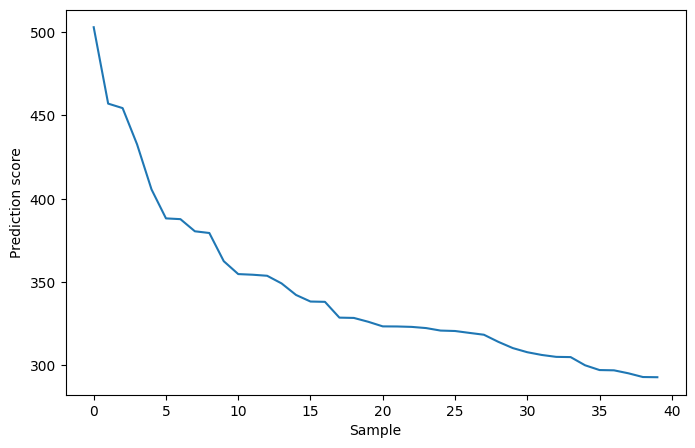

Evaluate score  13.931654899485869


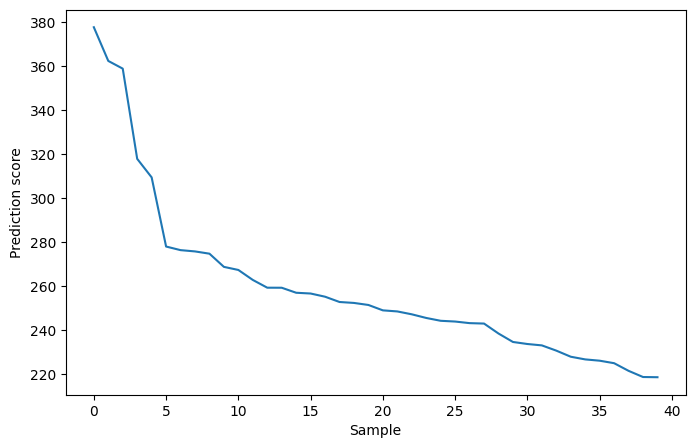

Evaluate score  10.934362995278969


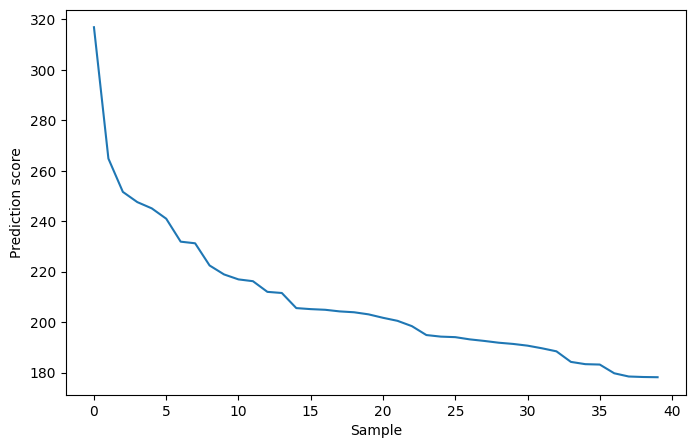

Evaluate score  8.574799361423535


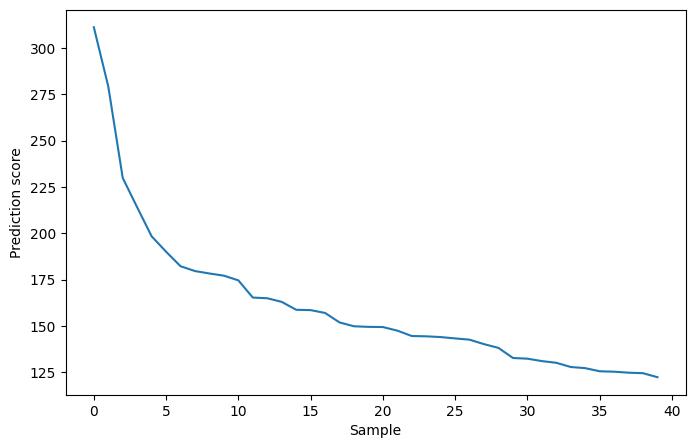

Evaluate score  7.036885515941076


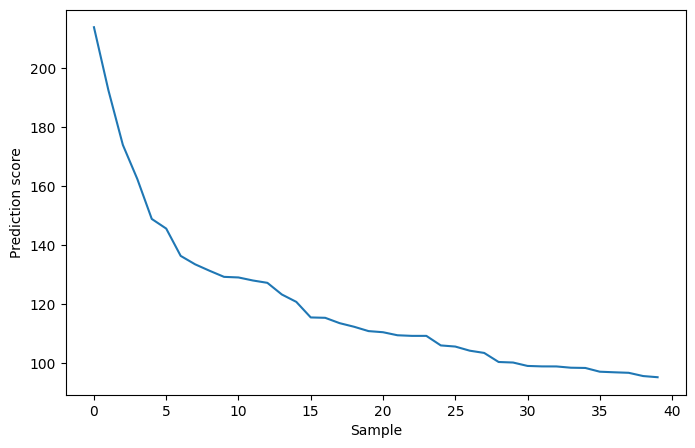

Evaluate score  6.179495155461737


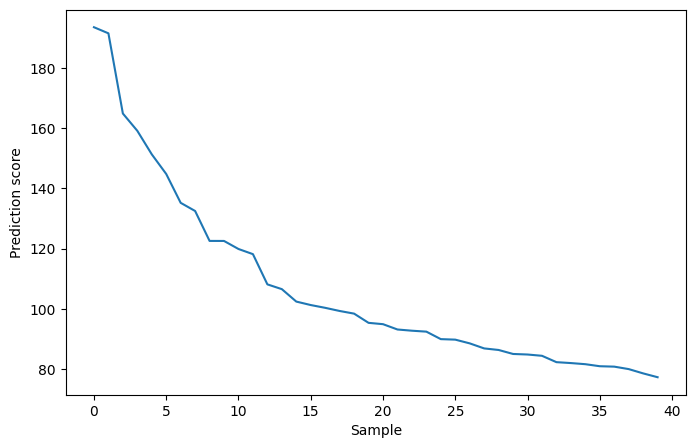

Evaluate score  5.1788169914319


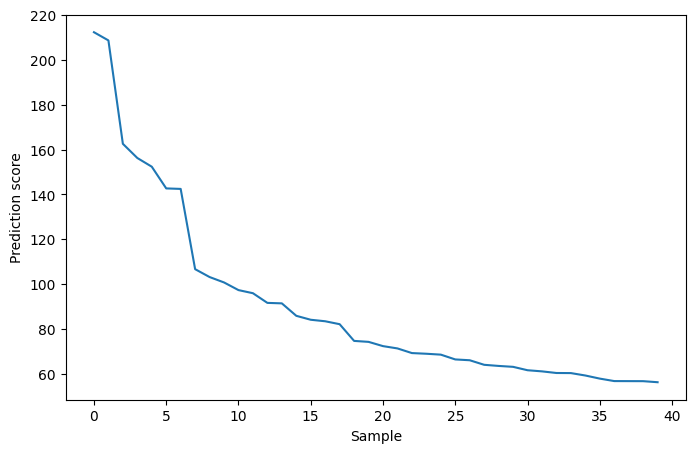

Evaluate score  4.58459254663834


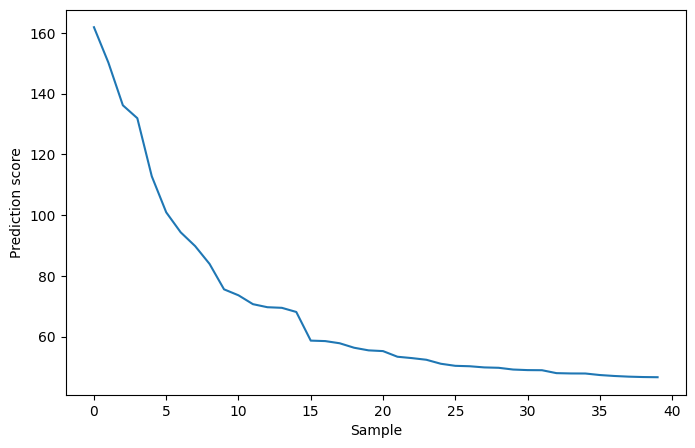

Evaluate score  4.123834061219884


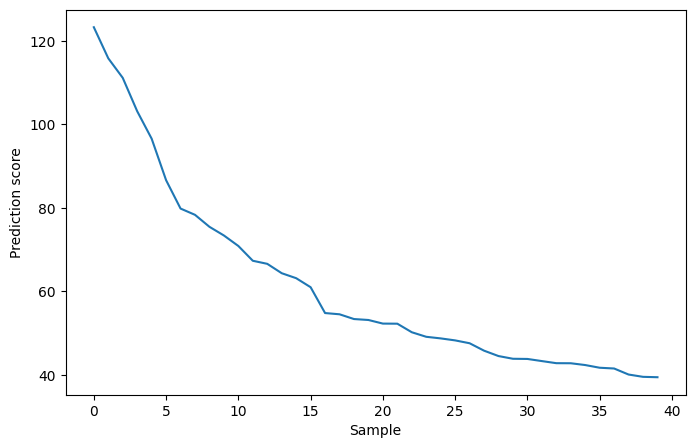

Evaluate score  3.760150448938704


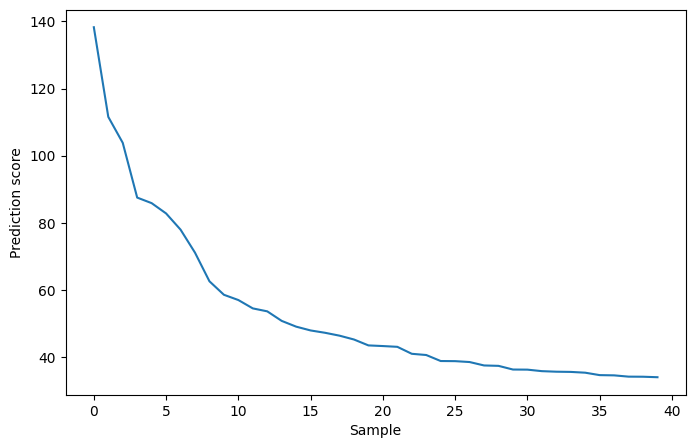

removed  0.1495433789954338
r2 score
-----------Hour-----------
Mean  0.9137696541513487
Std  0.005208404332852225


In [103]:
# New method
from common import find_outliers
X_numpy = X.to_numpy()
y_numpy = y.to_numpy()

outliers_mask, score = find_outliers(
    X_numpy,
    y_numpy,
    special_model,
    outliers_to_remove=0.15,
    iterations=10,
    gamma=0.99,
    evaluate_loss=metrics.mean_squared_error,
    cv=5,
    repeats=3,
    plot=True
)
print("removed ",np.sum(outliers_mask)/len(y))
X_clean = X_numpy[~outliers_mask]
y_clean = y_numpy[~outliers_mask]

r2_scoring = metrics.make_scorer(metrics.r2_score)
print("r2 score")
cross_val_score_mean_std(cross_val_score(special_model,X_clean,y_clean,cv=cv,scoring=r2_scoring),y.name)


In [114]:
X_clean = X_numpy[~outliers_mask]
y_clean = y_numpy[~outliers_mask][:,np.newaxis]

X_clean_small = pca.transform(scaler.transform(X_clean))
to_render=np.concatenate([X_clean_small,np.ones_like(y_clean),y_clean],axis=1)
plot_2d_rgb(to_render[:,[4,3,2,1,0]],"clean data",["d1","d2",'d3'],template='plotly_dark',dot_size=8)

/home/vlad/Programs/Git/python-outliers-detector/venv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names



In [ ]:
# z-score method
from scipy import stats
data = pd.concat([X,y],axis=1)
z = np.abs(stats.zscore(data))
threshold = 3
data_clean = data[(z < threshold).all(axis=1)]

X_clean=data_clean.iloc[:,:-2]
y_clean=data_clean.iloc[:,-1]

r2_scoring = metrics.make_scorer(metrics.r2_score)
print("r2 score")
cross_val_score_mean_std(cross_val_score(special_model,X_clean,y_clean,cv=cv,scoring=r2_scoring),y.name)

In [ ]:

import pandas as pd

# Assuming 'data' is a Pandas DataFrame
Q1 = data.quantile(0.05)
Q3 = data.quantile(0.95)
IQR = Q3 - Q1
data_clean = data[~((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).any(axis=1)]

X_clean=data_clean.iloc[:,:-2]
y_clean=data_clean.iloc[:,-1]

r2_scoring = metrics.make_scorer(metrics.r2_score)
cross_val_score_mean_std(cross_val_score(special_model,X_clean,y_clean,cv=cv,scoring=r2_scoring),y.name)

In [ ]:
from sklearn.ensemble import IsolationForest


clf = IsolationForest(random_state=50)
outliers_pred=clf.fit_predict(data)

data_clean = data[outliers_pred==1]

X_clean=data_clean.iloc[:,:-2]
y_clean=data_clean.iloc[:,-1]

r2_scoring = metrics.make_scorer(metrics.r2_score)
cross_val_score_mean_std(cross_val_score(special_model,X_clean,y_clean,cv=cv,scoring=r2_scoring),y.name)

Compare performance with some control model `KernelRidge` with `rbf` kernel and standard scaler

do parameters search for it using `RandomSearchCV`